In [2]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from plotnine import ggplot, aes
import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

# Training dataset - prenatal skin: load and subsample

In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

In [4]:
#load data object: prenatal skin only, post qc

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
fskin = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [5]:
fskin

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
  

In [6]:
fskin_ad1 = sk.subsample(fskin, fraction=1, groupby="joint_annotation_20220202", max_n=500).copy()

In [7]:
fskin_ad1

AnnData object with n_obs × n_vars = 28595 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
   

In [8]:
fskin_ad1.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,independent_annotation_broad1_20220201,independent_annotation_broad2_20220201,independent_annotation_broad3_20220201,joint_annotation_20220201a,joint_annotation_20220201b,fig1b_annotation_20220201,fig1b_annotation_20220202,joint_annotation_20220202,fig1b_annotation_v2,independent_annotation_refined_20220202
index,,,,,,,,,,,,,,,,,,,,,
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,Granulocyte progenitor,Granulocyte progenitor,Granulocyte progenitor,Eo/baso/mast cell progenitor,Eo/baso/mast cell progenitor,Progenitor,Progenitor,Eo/baso/mast cell progenitor,Haem progenitor,Eo/baso/mast cell progenitor
AACCATGAGATCTGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,DC2,cDC,DC,DC2,DC2,cDC,cDC,DC2,DC,DC2
AATCGGTAGTACGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.114754,...,Monocyte,Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte (activated/differentiating),Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte,Monocyte (activated/differentiating)
ACACTGAAGCCAGAAC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.254438,...,Macrophage,Macrophage,Macrophage,Activated mac,Activated mac,Macrophage,Macrophage,Iron-recycling macrophage,Macrophage,Iron-recycling macrophage
ACATGGTCATCGGGTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,Monocyte precursor,Monocyte precursor,Monocyte precursor,Monocyte precursor,Monocyte precursor,Monocyte,Monocyte,Monocyte precursor,Monocyte,Monocyte precursor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTCAATACC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Empt,0.055556,...,HF KC,HF KC,KC,Matrix/placode,Matrix/placode,Keratinocyte,Keratinocyte,Placode/matrix,Keratinocyte,Hair follicle KC
TTTGGTTGTCGCGTGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.114754,...,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte,Melanocyte
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,Early erythroid,Erythroid,Erythroid,Early erythroid,Early erythroid,Erythroid,Erythroid,Early erythroid,Erythroid,Early erythroid


# Target dataset - vascular organoid: load and log-norm

In [9]:
#vascular organoid data from: doi: https://doi.org/10.1101/2022.03.23.485329
#converted from rds to h5ad - keeping raw compartment
vasc_org = sc.read('/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/data/vasc_org_raw.h5ad')

In [10]:
vasc_org

AnnData object with n_obs × n_vars = 52680 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'line', 'group', 'culture', 'species', 'barcode', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'timepoint', 'seurat_clusters', 'RNA_css_snn_res.0.1', 'RNA_css_snn_res.0.5', 'RNA_css_snn_res.0.6', 'RNA_css_snn_res.0.8', 'RNA_css_snn_res.1', 'RNA_css_snn_res.2', 'RNA_css_snn_res.20', 'RNA_mnn_snn_res.0.1', 'RNA_mnn_snn_res.0.5', 'RNA_mnn_snn_res.0.8', 'RNA_mnn_snn_res.1', 'RNA_mnn_snn_res.2', 'RNA_mnn_snn_res.20', 'annot_celltype', 'day'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [11]:
vasc_org.X.data

array([ 1.,  1.,  1., ..., 24.,  7., 32.], dtype=float32)

In [12]:
vasc_org.X.max()

7141.0

## Load object with embedding to check

In [12]:
#vascular organoid data from: doi: https://doi.org/10.1101/2022.03.23.485329
#converted from rds to h5ad - keeping normalised, scaled compartment with embeddings
vasc_org2 = sc.read('/home/jovyan/mount_farm/nfs/nfs/team298/wt1/handover_skin/data/endothelial_organoid_timepoints.h5ad')

In [13]:
vasc_org2

AnnData object with n_obs × n_vars = 52680 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'line', 'group', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'timepoint', 'seurat_clusters', 'RNA_css_snn_res.0.1', 'RNA_css_snn_res.0.5', 'RNA_css_snn_res.0.6', 'RNA_css_snn_res.0.8', 'RNA_css_snn_res.1', 'RNA_css_snn_res.2', 'RNA_css_snn_res.20', 'RNA_mnn_snn_res.0.1', 'RNA_mnn_snn_res.0.5', 'RNA_mnn_snn_res.0.8', 'RNA_mnn_snn_res.1', 'RNA_mnn_snn_res.2', 'RNA_mnn_snn_res.20', 'annot_celltype', 'day'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_css', 'X_css_pca', 'X_mnn', 'X_pca', 'X_umap', 'X_umap3d_css', 'X_umap3d_mnn', 'X_umap_css', 'X_umap_mnn'

/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


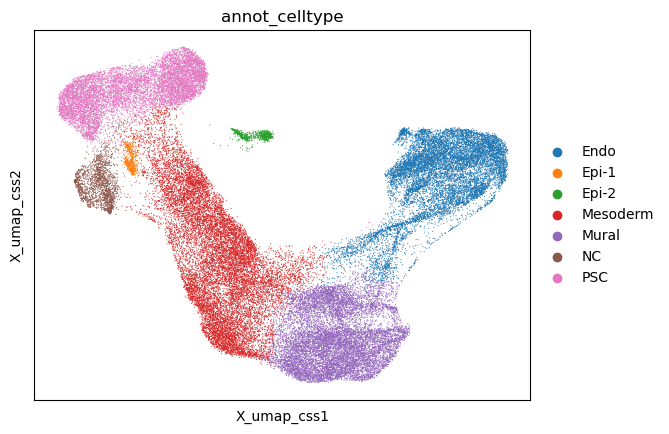

In [14]:
sc.pl.embedding(vasc_org2, basis='X_umap_css', color='annot_celltype')

/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


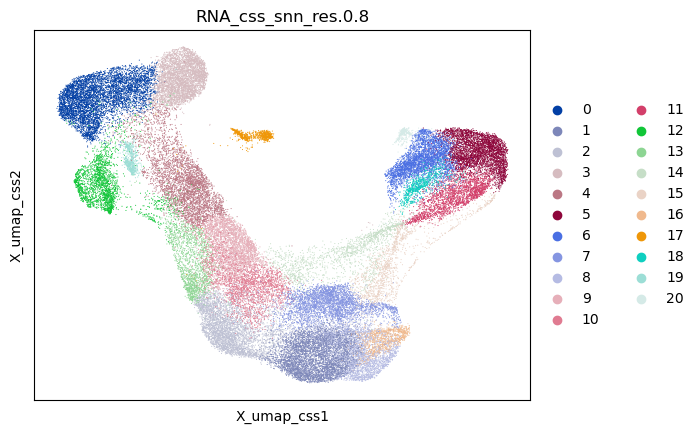

In [15]:
sc.pl.embedding(vasc_org2, basis='X_umap_css', color='RNA_css_snn_res.0.8')

In [16]:
vasc_org.obsm['X_umap_css'] = vasc_org2.obsm['X_umap_css'] 

In [17]:
vasc_org

AnnData object with n_obs × n_vars = 52680 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'line', 'group', 'culture', 'species', 'barcode', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'timepoint', 'seurat_clusters', 'RNA_css_snn_res.0.1', 'RNA_css_snn_res.0.5', 'RNA_css_snn_res.0.6', 'RNA_css_snn_res.0.8', 'RNA_css_snn_res.1', 'RNA_css_snn_res.2', 'RNA_css_snn_res.20', 'RNA_mnn_snn_res.0.1', 'RNA_mnn_snn_res.0.5', 'RNA_mnn_snn_res.0.8', 'RNA_mnn_snn_res.1', 'RNA_mnn_snn_res.2', 'RNA_mnn_snn_res.20', 'annot_celltype', 'day'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_umap_css'

In [18]:
del vasc_org2

In [19]:
vasc_org.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample,line,group,culture,species,barcode,...,RNA_css_snn_res.2,RNA_css_snn_res.20,RNA_mnn_snn_res.0.1,RNA_mnn_snn_res.0.5,RNA_mnn_snn_res.0.8,RNA_mnn_snn_res.1,RNA_mnn_snn_res.2,RNA_mnn_snn_res.20,annot_celltype,day
SC_AAACCCAAGCTTAGTC,H9_NC8_SC,10419.0,3416,6.900854,SC,H9,SC_H9,invitro,NA,NA,...,2,154,3,5,3,2,1,32,PSC,0.0
SC_AAACCCAAGTAATCCC,H9_NC8_SC,13986.0,3869,10.474760,SC,H9,SC_H9,invitro,NA,NA,...,2,191,3,4,1,0,18,0,PSC,0.0
SC_AAACCCACACTGGACC,H9_NC8_SC,15799.0,4345,9.399329,SC,H9,SC_H9,invitro,NA,NA,...,8,152,3,4,1,0,4,2,PSC,0.0
SC_AAACCCAGTCGTATTG,H9_NC8_SC,4456.0,2024,6.867145,SC,H9,SC_H9,invitro,NA,NA,...,2,69,3,4,1,0,18,6,PSC,0.0
SC_AAACCCAGTCGTGGAA,H9_NC8_SC,25285.0,5400,9.337552,SC,H9,SC_H9,invitro,NA,NA,...,0,99,3,4,1,0,4,10,PSC,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC8day14_TTTGTTGAGCCTCTCT-1,NC8day14,23849.0,5613,4.050484,NC8_D14,NC8,NC8_D14,invitro,NA,NA,...,12,136,0,7,0,3,17,107,Mural,14.0
NC8day14_TTTGTTGAGTTCCGGC-1,NC8day14,76051.0,8472,5.024260,NC8_D14,NC8,NC8_D14,invitro,NA,NA,...,25,33,1,6,8,4,21,125,Endo,14.0
NC8day14_TTTGTTGGTGGATCAG-1,NC8day14,123561.0,9540,8.327870,NC8_D14,NC8,NC8_D14,invitro,NA,NA,...,12,129,0,7,11,8,11,41,Mural,14.0
NC8day14_TTTGTTGGTGGGTATG-1,NC8day14,32036.0,6177,3.577226,NC8_D14,NC8,NC8_D14,invitro,NA,NA,...,17,156,0,7,11,8,11,160,Mural,14.0


In [13]:
sc.pp.normalize_total(vasc_org, target_sum=1e4)

In [14]:
sc.pp.log1p(vasc_org)

# Pool training and target datasets

In [15]:
#fskin_ad1: downsampled prenatal skin data as training/reference dataset
#vasc_org: vascular orgnaoid dataset as target/projection
pooled1 = sk.integrate(
    [fskin_ad1, vasc_org],
    ad_prefices=["fs", "or"],
    ad_types=["norm", "norm"],
    annotations=["joint_annotation_20220202", "annot_celltype"],
    batches=["donor", "group"],
    pool_only=True,
)

In [16]:
pooled1

AnnData object with n_obs × n_vars = 81275 × 20225
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'annot', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'orig.ident', 'nCount_

In [17]:
pooled1.obs

,sanger_id,chemistry,batch,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,RNA_css_snn_res.2,RNA_css_snn_res.20,RNA_mnn_snn_res.0.1,RNA_mnn_snn_res.0.5,RNA_mnn_snn_res.0.8,RNA_mnn_snn_res.1,RNA_mnn_snn_res.2,RNA_mnn_snn_res.20,day,dataset
AAAGTAGCAGATCGGA-1-4834STDY7002879-fs,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fs
AACCATGAGATCTGCT-1-4834STDY7002879-fs,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fs
AATCGGTAGTACGTAA-1-4834STDY7002879-fs,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.114754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fs
ACACTGAAGCCAGAAC-1-4834STDY7002879-fs,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.254438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fs
ACATGGTCATCGGGTC-1-4834STDY7002879-fs,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC8day14_TTTGTTGAGCCTCTCT-1-or,NaN,NaN,NC8_D14,NaN,NaN,NaN,NC8_D14,NaN,NaN,NaN,...,12.0,136.0,0.0,7.0,0.0,3.0,17.0,107.0,14.0,or
NC8day14_TTTGTTGAGTTCCGGC-1-or,NaN,NaN,NC8_D14,NaN,NaN,NaN,NC8_D14,NaN,NaN,NaN,...,25.0,33.0,1.0,6.0,8.0,4.0,21.0,125.0,14.0,or
NC8day14_TTTGTTGGTGGATCAG-1-or,NaN,NaN,NC8_D14,NaN,NaN,NaN,NC8_D14,NaN,NaN,NaN,...,12.0,129.0,0.0,7.0,11.0,8.0,11.0,41.0,14.0,or
NC8day14_TTTGTTGGTGGGTATG-1-or,NaN,NaN,NC8_D14,NaN,NaN,NaN,NC8_D14,NaN,NaN,NaN,...,17.0,156.0,0.0,7.0,11.0,8.0,11.0,160.0,14.0,or


In [18]:
pooled1.var.rename(columns={"cc-fs": "cc"}, inplace=True)

In [ ]:
pooled_ad = sk.simple_default_pipeline(
    pooled1,
    post_norm_only=True,
    batch_method="harmony",
    batch=["dataset", "batch"],
    hvg_kw={"by_batch": ("dataset", 2)},
    pca_kw={"remove_genes": ["mito", "ribo", "cc"]},
    hm_kw={"max_iter_harmony": 30},
)

2023-06-21 15:11:24,555 - harmonypy - INFO - Iteration 1 of 30
2023-06-21 15:14:27,664 - harmonypy - INFO - Iteration 2 of 30
2023-06-21 15:17:26,052 - harmonypy - INFO - Iteration 3 of 30


/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


Text(89.58333333333333, 0.5, 'UMAP2')

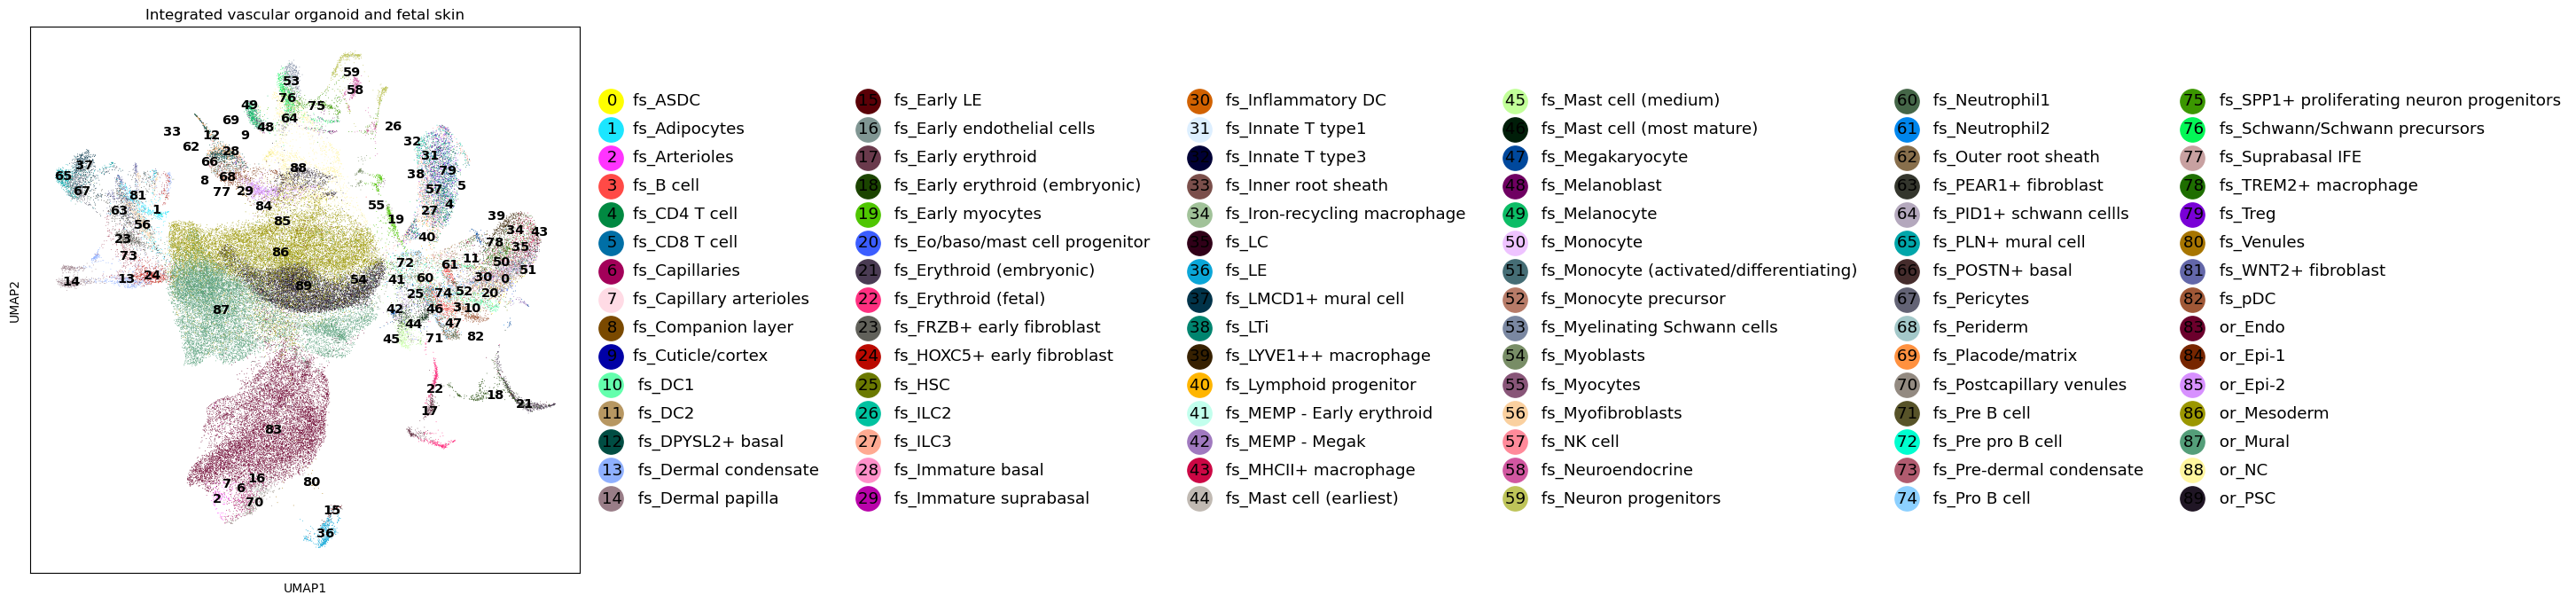

In [26]:
ax = sk.plot_embedding(
    pooled_ad,
    basis="umap_hm",
    groupby="annot",
    figsize=(8, 8),
    legend_fontsize=12,
    title="Integrated vascular organoid and fetal skin",
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
#plt.gcf().savefig("integrated_umap.pdf", bbox_inches="tight")

/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


Text(89.58333333333333, 0.5, 'UMAP2')

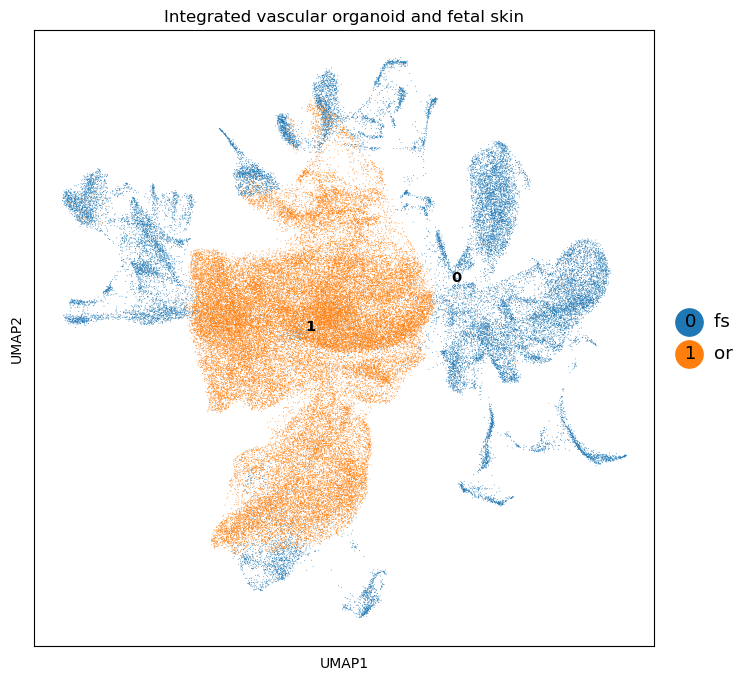

In [27]:
ax = sk.plot_embedding(
    pooled_ad,
    basis="umap_hm",
    groupby="dataset",
    figsize=(8, 8),
    legend_fontsize=12,
    title="Integrated vascular organoid and fetal skin",
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
#plt.gcf().savefig("integrated_umap.pdf", bbox_inches="tight")

/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/jovyan/my-conda-envs/sctk2_clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


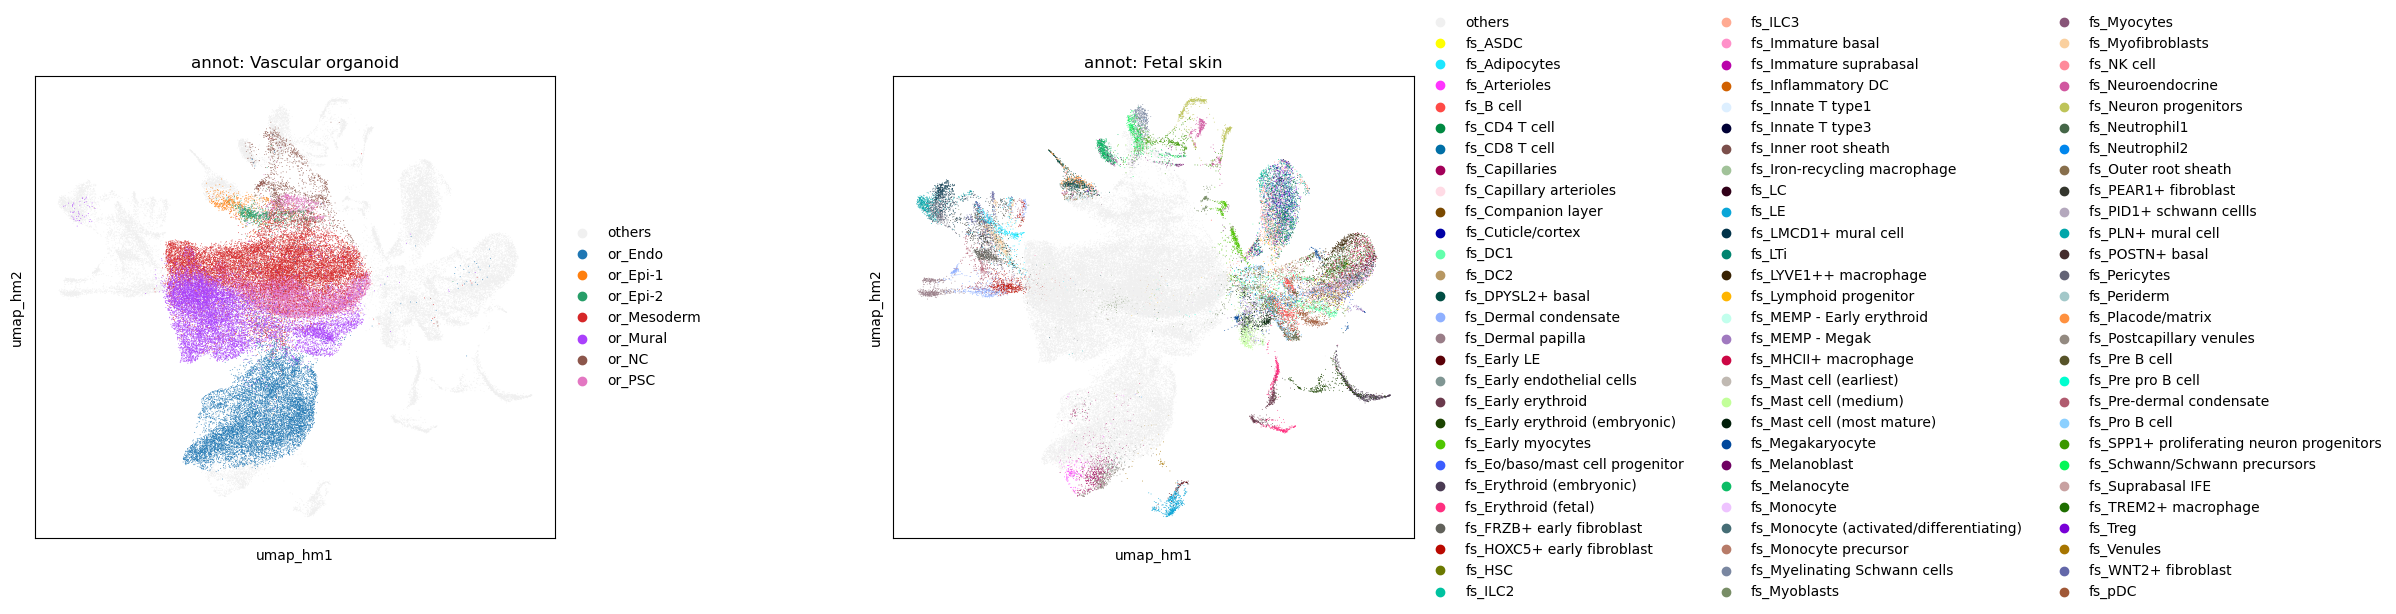

In [28]:
sk.highlight(
    pooled_ad,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"Vascular organoid": "or_", "Fetal skin": "fs_"},
    figsize=(6, 6),
    wspace=0.5,
);

In [22]:
save_path = '/home/jovyan/mount_farm/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/LR/LR_Ni_v4'

In [23]:
os.chdir('/home/jovyan/mount_farm/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/LR/LR_Ni_v4')

In [59]:
lr = sk.LR_train(fskin_ad1, groupby="joint_annotation_20220202", use_rep="X", save= 'LR_v5_08052023.pkl')

In [60]:
lr

LogisticRegression(C=0.1, n_jobs=-1, solver='saga', warm_start=True)

In [47]:
lr.classes_

array(['ASDC', 'Adipocytes', 'Arterioles', 'B cell', 'CD4 T cell', 'CD8 T cell', 'Capillaries', 'Capillary arterioles', 'Companion layer',
       'Cuticle/cortex', 'DC1', 'DC2', 'DPYSL2+ basal', 'Dermal condensate', 'Dermal papilla', 'Early LE', 'Early endothelial cells',
       'Early erythroid', 'Early erythroid (embryonic)', 'Early myocytes', 'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'HSC', 'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal',
       'Inflammatory DC', 'Innate T type1', 'Innate T type3', 'Inner root sheath', 'Iron-recycling macrophage', 'LC', 'LE', 'LMCD1+ mural cell',
       'LTi', 'LYVE1++ macrophage', 'Lymphoid progenitor', 'MEMP - Early erythroid', 'MEMP - Megak', 'MHCII+ macrophage', 'Mast cell (earliest)',
       'Mast cell (medium)', 'Mast cell (most mature)', 'Megakaryocyte', 'Melanoblast', 'Melanocyte', 'Monocyte',
       'Monocyte (activated/differentiating)'

In [28]:
#import pickle as pkl
#with open(save_path + '/LR_v5_08052023.pkl' , 'rb') as f:
#    lr = pkl.load(f)

In [23]:
lr_path = save_path + '/LR_v5_08052023.pkl'

In [24]:
lr = joblib.load(lr_path)

In [25]:
# returns ret
pred = sk.LR_predict(vasc_org, lr, use_rep="X", key_added="fskin_lr_v5", return_predict=True)

20225 features used for prediction


In [26]:
vasc_org

AnnData object with n_obs × n_vars = 52680 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'line', 'group', 'culture', 'species', 'barcode', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'timepoint', 'seurat_clusters', 'RNA_css_snn_res.0.1', 'RNA_css_snn_res.0.5', 'RNA_css_snn_res.0.6', 'RNA_css_snn_res.0.8', 'RNA_css_snn_res.1', 'RNA_css_snn_res.2', 'RNA_css_snn_res.20', 'RNA_mnn_snn_res.0.1', 'RNA_mnn_snn_res.0.5', 'RNA_mnn_snn_res.0.8', 'RNA_mnn_snn_res.1', 'RNA_mnn_snn_res.2', 'RNA_mnn_snn_res.20', 'annot_celltype', 'day', 'fskin_lr_v5', 'fskin_lr_v5_prob'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'log1p'
    obsm: 'X_umap_css'

In [67]:
vasc_org.write(save_path + '/LR_v5_08052023.h5ad')

In [64]:
sk.get_top_LR_features(lr, group='Arterioles', n_top=10)

,gene,coef
626,GJA4,0.124538
10656,IGFBP3,0.118200
16568,CXCL12,0.099078
16744,UNC5B,0.081195
14759,IGF2,0.080258
9226,EGFL8,0.071872
17543,A2M,0.069758
25214,PRND,0.069662
21634,SLC9A3R2,0.068077
1137,CYR61,0.066581


In [51]:
groups = list(vasc_org.obs['fskin_lr_v5'].unique())
groups

['SPP1+ proliferating neuron progenitors',
 'MEMP - Early erythroid',
 'Neuron progenitors',
 'Early erythroid (embryonic)',
 'Neuroendocrine',
 'Placode/matrix',
 'MEMP - Megak',
 'Melanoblast',
 'Pre B cell',
 'Monocyte precursor',
 'LMCD1+ mural cell',
 'HSC',
 'Adipocytes',
 'Periderm',
 'HOXC5+ early fibroblast',
 'Myoblasts',
 'Pre pro B cell',
 'Early myocytes',
 'Lymphoid progenitor',
 'Capillaries',
 'Pericytes',
 'Immature basal',
 'Capillary arterioles',
 'Early endothelial cells',
 'CD4 T cell',
 'FRZB+ early fibroblast',
 'ILC3',
 'LYVE1++ macrophage',
 'WNT2+ fibroblast',
 'Pre-dermal condensate',
 'Postcapillary venules',
 'DPYSL2+ basal',
 'Arterioles',
 'PEAR1+ fibroblast',
 'Immature suprabasal',
 'Early erythroid',
 'PID1+ schwann cellls',
 'LTi',
 'Early LE',
 'Dermal condensate',
 'Dermal papilla',
 'Mast cell (earliest)',
 'Mast cell (most mature)',
 'LE',
 'PLN+ mural cell',
 'TREM2+ macrophage',
 'DC1',
 'B cell',
 'Myelinating Schwann cells',
 'Companion layer'

In [52]:
len(groups)

56

In [65]:
features_df = pd.DataFrame()
for celltype in groups:
    temp_df = sk.get_top_LR_features(lr, group=celltype, n_top=10)
    temp_df['group'] = celltype
    features_df = pd.concat([features_df, temp_df])

In [67]:
features_df
features_df.to_csv(save_path + '/features_lr5.csv')

In [29]:
pred

{'label': array(['SPP1+ proliferating neuron progenitors', 'SPP1+ proliferating neuron progenitors', 'MEMP - Early erythroid', ..., 'LMCD1+ mural cell',
        'LMCD1+ mural cell', 'Pericytes'], dtype=object),
 'prob':                                  ASDC  Adipocytes  Arterioles    B cell  \
 SC_AAACCCAAGCTTAGTC          0.000262    0.004172    0.000422  0.000525   
 SC_AAACCCAAGTAATCCC          0.000258    0.005594    0.000528  0.000506   
 SC_AAACCCACACTGGACC          0.000777    0.006254    0.000663  0.000897   
 SC_AAACCCAGTCGTATTG          0.000505    0.003963    0.001046  0.001206   
 SC_AAACCCAGTCGTGGAA          0.000266    0.002679    0.000288  0.000313   
 ...                               ...         ...         ...       ...   
 NC8day14_TTTGTTGAGCCTCTCT-1  0.002616    0.014504    0.011321  0.000137   
 NC8day14_TTTGTTGAGTTCCGGC-1  0.001144    0.000317    0.025416  0.000019   
 NC8day14_TTTGTTGGTGGATCAG-1  0.004231    0.001557    0.010543  0.000027   
 NC8day14_TTTGTTGGTGG

In [33]:
# compute median probability prediction
prob_df = pd.DataFrame(
    npg.aggregate_np(
        vasc_org.obs.annot_celltype.cat.codes,
        pred["prob"].values,
        func=np.median,
        axis=0,
    ),
    index=vasc_org.obs.annot_celltype.cat.categories,
    columns=pred["prob"].columns,
)
prob_df
prob_df.to_csv(save_path + '/prob_df_lr5.csv')

In [41]:
# compute prediction by proportion
prop_df = pd.crosstab(vasc_org.obs.annot_celltype, pred["label"])
prop_df
#prop_df.to_csv(save_path + '/prop_df_lr5.csv')

col_0,Adipocytes,Arterioles,B cell,CD4 T cell,Capillaries,Capillary arterioles,Companion layer,DC1,DPYSL2+ basal,Dermal condensate,...,Periderm,Placode/matrix,Postcapillary venules,Pre B cell,Pre pro B cell,Pre-dermal condensate,SPP1+ proliferating neuron progenitors,Schwann/Schwann precursors,TREM2+ macrophage,WNT2+ fibroblast
annot_celltype,,,,,,,,,,,,,,,,,,,,,
Endo,31,2252,1,9,71,5058,0,2,0,1,...,1,6,657,5,1,2,136,0,2,1
Epi-1,1,0,0,0,0,0,0,0,0,0,...,387,36,0,2,0,0,30,0,1,0
Epi-2,44,0,0,1,0,5,2,0,0,0,...,189,50,0,1,0,0,105,0,0,0
Mesoderm,1373,1,0,9,5,96,0,0,1,2,...,83,130,0,28,5,100,1823,0,1,12
Mural,97,2,0,1,3,324,0,1,0,0,...,0,10,63,0,0,193,78,3,0,10
NC,1,0,0,3,0,0,0,0,0,0,...,2,4,0,3,0,0,1234,0,0,0
PSC,2,0,0,1,0,1,0,0,0,0,...,5,39,0,3,1,0,4188,0,0,0


In [46]:
# convert prediction by proportion to percentage
#prop_df = prop_df.set_index('annot_celltype')
prop_df_pct = prop_df.div(prop_df.sum(axis=1), axis=0).mul(100).round(2)
#prop_df_pctres.reset_index()
prop_df_pct
prop_df_pct.to_csv(save_path + '/prop_df_pct_lr5.csv')

# Plotting

## Include all labels

In [1]:
sk.set_figsize((20, 3))
ax = sn.heatmap(
    sk.cross_table(vasc_org, "annot_celltype", "fskin_lr_v5", normalise="jaccard"),
    cmap="viridis_r",linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");
#plt.savefig("vasc_org_lr_prop.pdf", bbox_inches="tight")

NameError: name 'sk' is not defined

In [39]:
to_plot = sk.cross_table(vasc_org, "annot_celltype", "fskin_lr_v5", normalise="jaccard")
to_plot

fskin_lr_v5,Adipocytes,Arterioles,B cell,CD4 T cell,Capillaries,Capillary arterioles,Companion layer,DC1,DPYSL2+ basal,Dermal condensate,...,Periderm,Placode/matrix,Postcapillary venules,Pre B cell,Pre pro B cell,Pre-dermal condensate,SPP1+ proliferating neuron progenitors,Schwann/Schwann precursors,TREM2+ macrophage,WNT2+ fibroblast
annot_celltype,,,,,,,,,,,,,,,,,,,,,
Endo,0.0022,0.1836,0.0001,0.0007,0.0058,0.3985,0.0000,0.0002,0.0000,0.0001,...,0.0001,0.0005,0.0533,0.0004,0.0001,0.0002,0.0069,0.0000,0.0002,0.0001
Epi-1,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.4433,0.0433,0.0000,0.0032,0.0000,0.0000,0.0037,0.0000,0.0017,0.0000
Epi-2,0.0193,0.0000,0.0000,0.0013,0.0000,0.0008,0.0026,0.0000,0.0000,0.0000,...,0.1507,0.0500,0.0000,0.0012,0.0000,0.0000,0.0127,0.0000,0.0000,0.0000
Mesoderm,0.0887,0.0001,0.0000,0.0006,0.0003,0.0046,0.0000,0.0000,0.0001,0.0001,...,0.0052,0.0084,0.0000,0.0018,0.0003,0.0065,0.0865,0.0000,0.0001,0.0008
Mural,0.0070,0.0001,0.0000,0.0001,0.0002,0.0185,0.0000,0.0001,0.0000,0.0000,...,0.0000,0.0008,0.0048,0.0000,0.0000,0.0154,0.0039,0.0002,0.0000,0.0008
NC,0.0003,0.0000,0.0000,0.0015,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0008,0.0018,0.0000,0.0015,0.0000,0.0000,0.1484,0.0000,0.0000,0.0000
PSC,0.0002,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,...,0.0005,0.0040,0.0000,0.0003,0.0001,0.0000,0.3272,0.0000,0.0000,0.0000


In [43]:
# orders both rows and columns by max value first
index_order = list(to_plot2.max(axis=1).sort_values(ascending=False).index)
col_order = list(to_plot2.max(axis=0).sort_values(ascending=False).index)
to_plot2 = to_plot2.loc[index_order]
to_plot2 = to_plot2[col_order]
to_plot2

fskin_lr_v5,Periderm,Pericytes,Capillary arterioles,SPP1+ proliferating neuron progenitors,LMCD1+ mural cell,Early endothelial cells,MEMP - Early erythroid,Arterioles,Neuroendocrine,HOXC5+ early fibroblast,...,ILC3,Schwann/Schwann precursors,Neutrophil1,Early erythroid,Mast cell (earliest),DPYSL2+ basal,Dermal condensate,Innate T type3,B cell,Dermal papilla
annot_celltype,,,,,,,,,,,,,,,,,,,,,
Epi-1,0.4433,0.0001,0.0000,0.0037,0.0000,0.0000,0.0002,0.0000,0.0195,0.0007,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mural,0.0000,0.4106,0.0185,0.0039,0.2754,0.0043,0.0017,0.0001,0.0019,0.0267,...,0.0002,0.0002,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
Endo,0.0001,0.0095,0.3985,0.0069,0.0018,0.2418,0.0075,0.1836,0.0017,0.0029,...,0.0002,0.0000,0.0001,0.0000,0.0001,0.0000,0.0001,0.0000,0.0001,0.0001
PSC,0.0005,0.0000,0.0001,0.3272,0.0000,0.0002,0.2242,0.0000,0.0379,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Epi-2,0.1507,0.0000,0.0008,0.0127,0.0000,0.0015,0.0276,0.0000,0.0245,0.0017,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
NC,0.0008,0.0001,0.0000,0.1484,0.0001,0.0000,0.0011,0.0000,0.1370,0.0014,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mesoderm,0.0052,0.0532,0.0046,0.0865,0.0597,0.0020,0.1163,0.0001,0.1199,0.1122,...,0.0001,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000


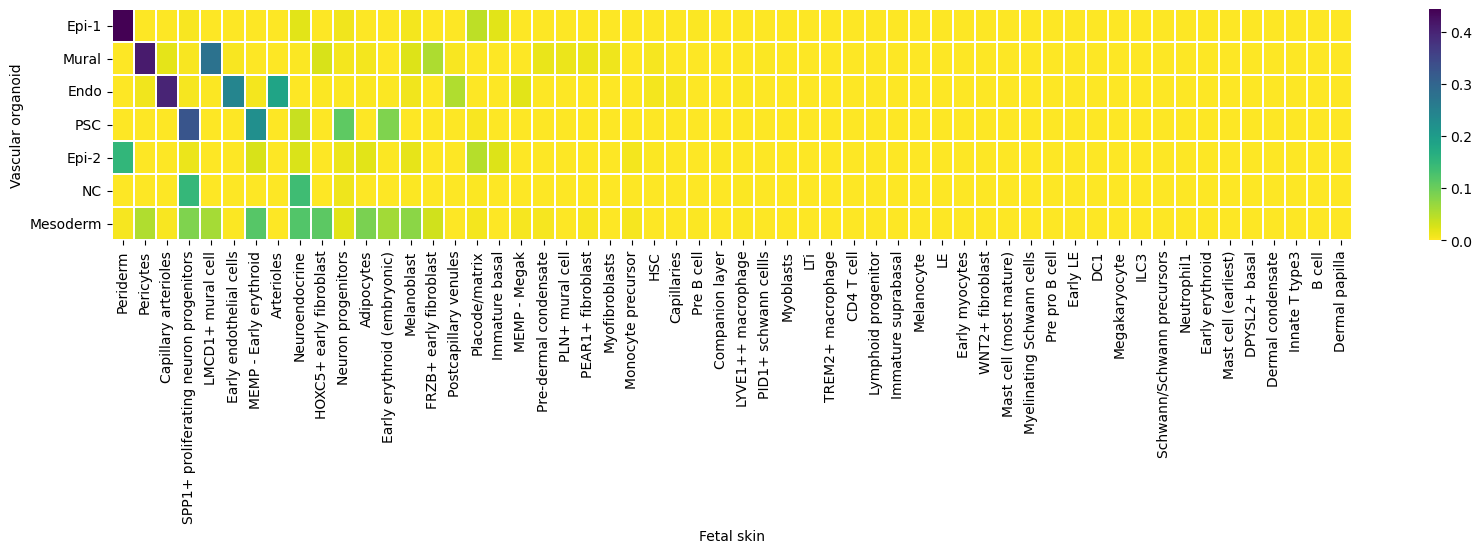

In [44]:
sk.set_figsize((20, 3))
ax = sn.heatmap(to_plot2,
    annot=False,
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");

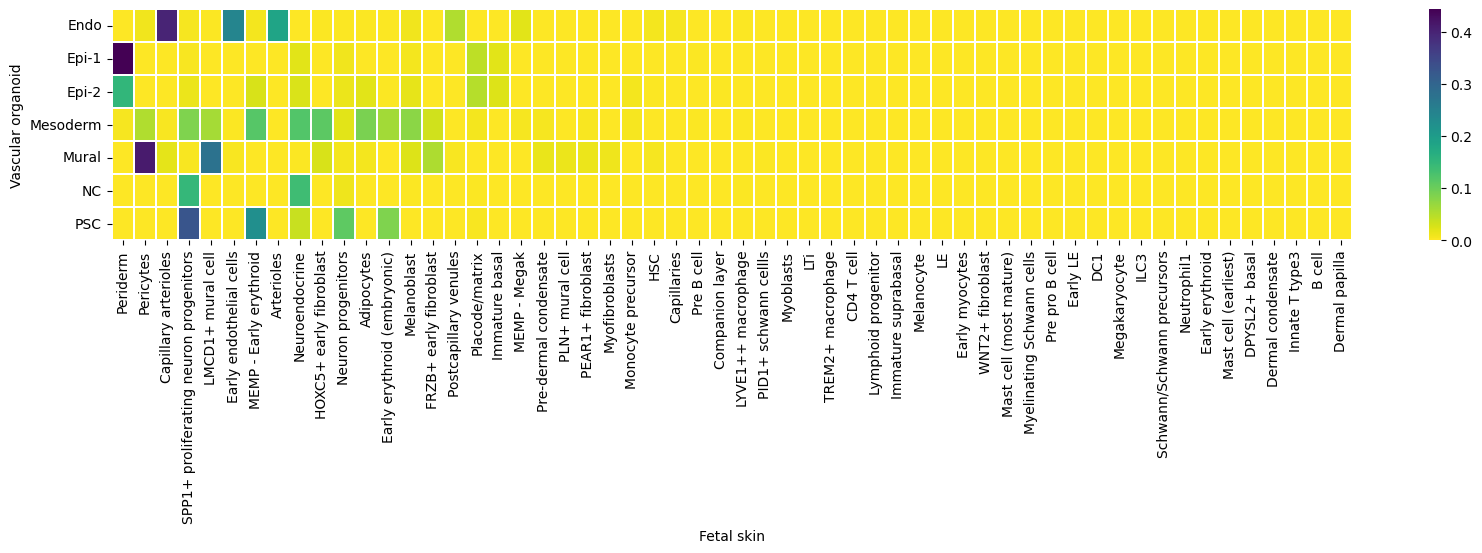

In [47]:
sk.set_figsize((20, 3))
ax = sn.heatmap(to_plot2,
    annot=False,
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");

## Filter based on jaccard index

In [50]:
filtered_plot= to_plot.loc[:, to_plot.max() > 0.1]
filtered_plot

fskin_lr_v5,Arterioles,Capillary arterioles,Early endothelial cells,HOXC5+ early fibroblast,LMCD1+ mural cell,MEMP - Early erythroid,Neuroendocrine,Neuron progenitors,Pericytes,Periderm,SPP1+ proliferating neuron progenitors
annot_celltype,,,,,,,,,,,
Endo,0.1836,0.3985,0.2418,0.0029,0.0018,0.0075,0.0017,0.0027,0.0095,0.0001,0.0069
Epi-1,0.0000,0.0000,0.0000,0.0007,0.0000,0.0002,0.0195,0.0094,0.0001,0.4433,0.0037
Epi-2,0.0000,0.0008,0.0015,0.0017,0.0000,0.0276,0.0245,0.0129,0.0000,0.1507,0.0127
Mesoderm,0.0001,0.0046,0.0020,0.1122,0.0597,0.1163,0.1199,0.0193,0.0532,0.0052,0.0865
Mural,0.0001,0.0185,0.0043,0.0267,0.2754,0.0017,0.0019,0.0072,0.4106,0.0000,0.0039
NC,0.0000,0.0000,0.0000,0.0014,0.0001,0.0011,0.1370,0.0118,0.0001,0.0008,0.1484
PSC,0.0000,0.0001,0.0002,0.0000,0.0000,0.2242,0.0379,0.1107,0.0000,0.0005,0.3272


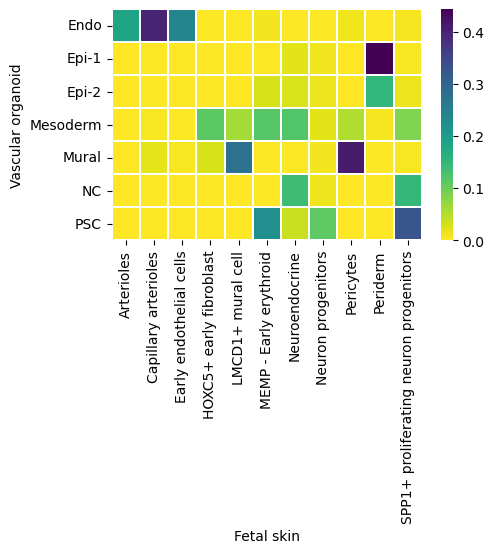

In [51]:
sk.set_figsize((5, 3))
ax = sn.heatmap(filtered_plot,
    annot=False,
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");

In [54]:
col_order2 = ['Early endothelial cells', 'Capillary arterioles', 'Arterioles', 'Periderm', 'HOXC5+ early fibroblast', 
              'LMCD1+ mural cell', 'Pericytes', 'MEMP - Early erythroid', 'Neuroendocrine', 'SPP1+ proliferating neuron progenitors','Neuron progenitors']
filtered_plot_ordered= filtered_plot[col_order2]
filtered_plot_ordered

fskin_lr_v5,Early endothelial cells,Capillary arterioles,Arterioles,Periderm,HOXC5+ early fibroblast,LMCD1+ mural cell,Pericytes,MEMP - Early erythroid,Neuroendocrine,SPP1+ proliferating neuron progenitors,Neuron progenitors
annot_celltype,,,,,,,,,,,
Endo,0.2418,0.3985,0.1836,0.0001,0.0029,0.0018,0.0095,0.0075,0.0017,0.0069,0.0027
Epi-1,0.0000,0.0000,0.0000,0.4433,0.0007,0.0000,0.0001,0.0002,0.0195,0.0037,0.0094
Epi-2,0.0015,0.0008,0.0000,0.1507,0.0017,0.0000,0.0000,0.0276,0.0245,0.0127,0.0129
Mesoderm,0.0020,0.0046,0.0001,0.0052,0.1122,0.0597,0.0532,0.1163,0.1199,0.0865,0.0193
Mural,0.0043,0.0185,0.0001,0.0000,0.0267,0.2754,0.4106,0.0017,0.0019,0.0039,0.0072
NC,0.0000,0.0000,0.0000,0.0008,0.0014,0.0001,0.0001,0.0011,0.1370,0.1484,0.0118
PSC,0.0002,0.0001,0.0000,0.0005,0.0000,0.0000,0.0000,0.2242,0.0379,0.3272,0.1107


In [57]:
fig_save_path = '/home/jovyan/projects/skin/fetal_skin/figures/other plots/'

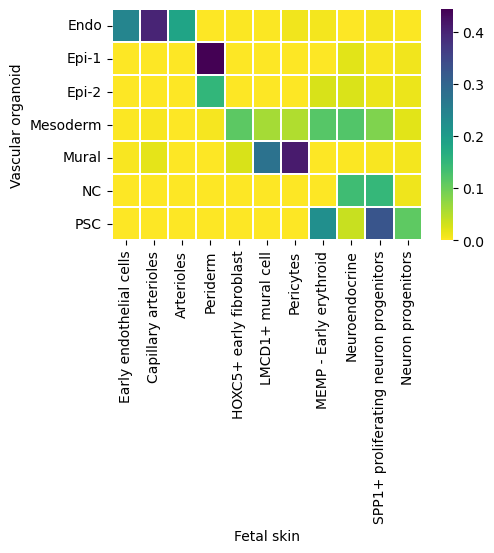

In [58]:
sk.set_figsize((5, 3))
ax = sn.heatmap(filtered_plot_ordered,
    annot=False,
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");
plt.gcf().savefig(fig_save_path + "vasc_org_LR1.pdf", bbox_inches="tight")

# Filtered to keep top 10 predicted cell types

In [60]:
filtered_top10  = to_plot2.iloc[:, :10]
filtered_top10

fskin_lr_v5,Periderm,Pericytes,Capillary arterioles,SPP1+ proliferating neuron progenitors,LMCD1+ mural cell,Early endothelial cells,MEMP - Early erythroid,Arterioles,Neuroendocrine,HOXC5+ early fibroblast
annot_celltype,,,,,,,,,,
Endo,0.0001,0.0095,0.3985,0.0069,0.0018,0.2418,0.0075,0.1836,0.0017,0.0029
Epi-1,0.4433,0.0001,0.0000,0.0037,0.0000,0.0000,0.0002,0.0000,0.0195,0.0007
Epi-2,0.1507,0.0000,0.0008,0.0127,0.0000,0.0015,0.0276,0.0000,0.0245,0.0017
Mesoderm,0.0052,0.0532,0.0046,0.0865,0.0597,0.0020,0.1163,0.0001,0.1199,0.1122
Mural,0.0000,0.4106,0.0185,0.0039,0.2754,0.0043,0.0017,0.0001,0.0019,0.0267
NC,0.0008,0.0001,0.0000,0.1484,0.0001,0.0000,0.0011,0.0000,0.1370,0.0014
PSC,0.0005,0.0000,0.0001,0.3272,0.0000,0.0002,0.2242,0.0000,0.0379,0.0000


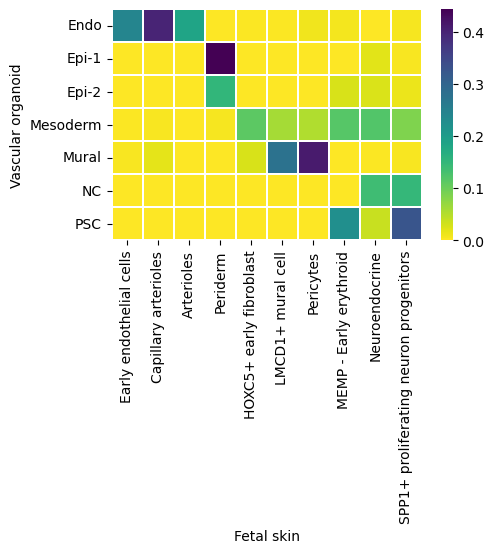

In [65]:
# showing top 10 predicted cell types
col_order3 = ['Early endothelial cells', 'Capillary arterioles', 'Arterioles', 'Periderm', 'HOXC5+ early fibroblast', 
              'LMCD1+ mural cell', 'Pericytes', 'MEMP - Early erythroid', 'Neuroendocrine', 'SPP1+ proliferating neuron progenitors']
filtered_top10_ordered= filtered_top10[col_order3]
filtered_top10_ordered

sk.set_figsize((5, 3))
ax = sn.heatmap(filtered_top10_ordered,
    annot=False,
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Fetal skin");
ax.set_ylabel("Vascular organoid");
plt.gcf().savefig(fig_save_path + "vasc_org_LR_top10.pdf", bbox_inches="tight")